In [1]:
import stan

import nest_asyncio # https://pystan.readthedocs.io/en/latest/faq.html
nest_asyncio.apply()

In [2]:
# reload packages from notebook whenever needed
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import arviz as az # For visualization and loo
import seaborn as sns 
from patsy import dmatrices

# Some math/information on  Bayesian Logistic Regression

Note regarding this section: Borrowing some content from the below authors

Authors: Jonah Gabry, Ben Goodrich, Aki Vehtari, Tuomas Sivula

The introduction to Bayesian logistic regression is from a [CRAN vignette](https://cran.r-project.org/web/packages/rstanarm/vignettes/binomial.html) by Jonah Gabry and Ben Goodrich. CRAN vignette was modified to a [R notebook](https://github.com/avehtari/BDA_R_demos/blob/master/demos_rstan/diabetes.Rmd) by Aki Vehtari.  Instead of wells data in CRAN vignette, Pima Indians data is used. The end of the notebook differs significantly from the CRAN vignette.  The R notebook was ported to this Python notebook by Aki Vehtari and Tuomas Sivula.

This vignette explains how to estimate generalized linear models (GLMs) for binary (Bernoulli) response variables using PyStan.

The four steps of a Bayesian analysis are

1. Specify a joint distribution for the outcome(s) and all the unknowns, which typically takes the form of a marginal prior distribution for the unknowns multiplied by a likelihood for the outcome(s) conditional on the unknowns. This joint distribution is proportional to a posterior distribution of the unknowns conditional on the observed data
2. Draw from posterior distribution using Markov Chain Monte Carlo (MCMC).
3. Evaluate how well the model fits the data and possibly revise the model.
4. Draw from the posterior predictive distribution of the outcome(s) given interesting values of the predictors in order to visualize how a manipulation of a predictor affects (a function of) the outcome(s).
This notebook demonstrates Steps 1-3 when the likelihood is the product of conditionally independent binomial distributions (possibly with only one trial per observation).

### Likelihood

For a binomial GLM the likelihood for one observation $y$ can be written as a conditionally binomial PMF $$\binom{n}{y} \pi^{y} (1 - \pi)^{n - y},$$ where $n$ is the known number of trials, $\pi = g^{-1}(\eta)$ is the probability of success and $\eta = \alpha + \mathbf{x}^\top \boldsymbol{\beta}$ is a linear predictor. For a sample of size $N$, the likelihood of the entire sample is the product of $N$ individual likelihood contributions.

Because $\pi$ is a probability, for a binomial model the link function $g$ maps between the unit interval (the support of $\pi$) and the set of all real numbers $\mathbb{R}$. When applied to a linear predictor $\eta$ with values in $\mathbb{R}$, the inverse link function $g^{-1}(\eta)$ therefore returns a valid probability between 0 and 1.

The two most common link functions used for binomial GLMs are the logit and probit functions. With the logit (or log-odds) link function $g(x) = \ln{\left(\frac{x}{1-x}\right)}$, the likelihood for a single observation becomes

$$\binom{n}{y}\left(\text{logit}^{-1}(\eta)\right)^y \left(1 - \text{logit}^{-1}(\eta)\right)^{n-y} = \binom{n}{y} \left(\frac{e^{\eta}}{1 + e^{\eta}}\right)^{y} \left(\frac{1}{1 + e^{\eta}}\right)^{n - y}$$

and the probit link function $g(x) = \Phi^{-1}(x)$ yields the likelihood

$$\binom{n}{y} \left(\Phi(\eta)\right)^{y} \left(1 - \Phi(\eta)\right)^{n - y},$$

where $\Phi$ is the CDF of the standard normal distribution. The differences between the logit and probit functions are minor and -- if, as rstanarm does by default, the probit is scaled so its slope at the origin matches the logit's -- the two link functions should yield similar results. Unless the user has a specific reason to prefer the probit link, we recommend the logit simply because it will be slightly faster and more numerically stable.

In theory, there are infinitely many possible link functions, although in practice only a few are typically used. 


### Priors

A full Bayesian analysis requires specifying prior distributions $f(\alpha)$ and $f(\boldsymbol{\beta})$ for the intercept and vector of regression coefficients. 

As an example, suppose we have $K$ predictors and believe --- prior to seeing the data --- that $\alpha, \beta_1, \dots, \beta_K$ are as likely to be positive as they are to be negative, but are highly unlikely to be far from zero. These beliefs can be represented by normal distributions with mean zero and a small scale (standard deviation).

If, on the other hand, we have less a priori confidence that the parameters will be close to zero then we could use a larger scale for the normal distribution and/or a distribution with heavier tails than the normal like the Student's $t$ distribution.

### Posterior

With independent prior distributions, the joint posterior distribution for $\alpha$ and $\boldsymbol{\beta}$ is proportional to the product of the priors and the $N$ likelihood contributions:

$$f\left(\alpha,\boldsymbol{\beta} | \mathbf{y},\mathbf{X}\right) \propto f\left(\alpha\right) \times \prod_{k=1}^K f\left(\beta_k\right) \times \prod_{i=1}^N { g^{-1}\left(\eta_i\right)^{y_i} \left(1 - g^{-1}\left(\eta_i\right)\right)^{n_i-y_i}}.$$

This is posterior distribution that PyStan will draw from when using MCMC.

When the logit link function is used the model is often referred to as a logistic regression model (the inverse logit function is the CDF of the standard logistic distribution). As an example, here we will show how to carry out a analysis for Pima Indians data set similar to analysis from Chapter 5.4 of Gelman and Hill (2007) using PyStan.

# Load some data, also borrowing from the above

In [4]:
data = pd.read_csv('data/diabetes.csv')

In [5]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [6]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


# Using Stan to fit a logistic regression

In [7]:
prior_width = 10^3 #uninformative prior

In [8]:
data.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [9]:
covariate_cols = [x for x in data.columns if x!= 'Outcome']
regeq = 'Outcome ~ 1 + {}'.format(' + '.join(covariate_cols))
y, X = dmatrices(regeq, data=data)

In [10]:
X

DesignMatrix with shape (768, 9)
  Columns:
    ['Intercept',
     'Pregnancies',
     'Glucose',
     'BloodPressure',
     'SkinThickness',
     'Insulin',
     'BMI',
     'DiabetesPedigreeFunction',
     'Age']
  Terms:
    'Intercept' (column 0)
    'Pregnancies' (column 1)
    'Glucose' (column 2)
    'BloodPressure' (column 3)
    'SkinThickness' (column 4)
    'Insulin' (column 5)
    'BMI' (column 6)
    'DiabetesPedigreeFunction' (column 7)
    'Age' (column 8)
  (to view full data, use np.asarray(this_obj))

In [11]:
np.asarray(X)

array([[  1.   ,   6.   , 148.   , ...,  33.6  ,   0.627,  50.   ],
       [  1.   ,   1.   ,  85.   , ...,  26.6  ,   0.351,  31.   ],
       [  1.   ,   8.   , 183.   , ...,  23.3  ,   0.672,  32.   ],
       ...,
       [  1.   ,   5.   , 121.   , ...,  26.2  ,   0.245,  30.   ],
       [  1.   ,   1.   , 126.   , ...,  30.1  ,   0.349,  47.   ],
       [  1.   ,   1.   ,  93.   , ...,  30.4  ,   0.315,  23.   ]])

In [12]:
y = [int(yy[0]) for yy in np.asarray(y)]

In [13]:
# int<lower=0> N;
# int<lower=1> Nattr; // number of covariates
# matrix[Nobs,Nattr] X;  
# array[N] int<lower=0, upper=1> Y;
# real<lower=0> prior_width;
stan_data = {
                'N' : len(y),
                'Nattr' : X.shape[1],
                'X' : X,
                'y' : y,
                'prior_width' : prior_width 
             }

In [14]:
stan_folder = 'stan_code/'
stan_file = stan_folder + 'logistic_regression.stan'
with open(stan_file) as file:
    model_code = file.read()
print(model_code)

// see following for vectorized logistic regression help
// https://mc-stan.org/docs/stan-users-guide/vectorization.html
data {
    int<lower=0> N;
    int<lower=1> Nattr; // number of covariates
    matrix[N,Nattr] X;  
    // array[N] vector[Nattr] X;

    array[N] int<lower=0> y;
    
    real<lower=0> prior_width;
}

parameters {
    vector[Nattr] beta;  // attribute effects 
}
model {
    beta ~ normal(0, prior_width);
    y ~ bernoulli_logit(X*beta);
}


In [15]:
compiled_model = stan.build(model_code, data=stan_data, random_seed=1)

Building...

In file included from /home/nkgarg/miniconda3/lib/python3.9/site-packages/httpstan/include/boost/multi_array/multi_array_ref.hpp:32,
                 from /home/nkgarg/miniconda3/lib/python3.9/site-packages/httpstan/include/boost/multi_array.hpp:34,
                 from /home/nkgarg/miniconda3/lib/python3.9/site-packages/httpstan/include/boost/numeric/odeint/algebra/multi_array_algebra.hpp:22,
                 from /home/nkgarg/miniconda3/lib/python3.9/site-packages/httpstan/include/boost/numeric/odeint.hpp:63,
                 from /home/nkgarg/miniconda3/lib/python3.9/site-packages/httpstan/include/stan/math/prim/functor/ode_rk45.hpp:9,
                 from /home/nkgarg/miniconda3/lib/python3.9/site-packages/httpstan/include/stan/math/prim/functor/integrate_ode_rk45.hpp:6,
                 from /home/nkgarg/miniconda3/lib/python3.9/site-packages/httpstan/include/stan/math/prim/functor.hpp:14,
                 from /home/nkgarg/miniconda3/lib/python3.9/site-packages/httpstan/include


Building: 20.2s, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


In [16]:
fit = compiled_model.sample(num_chains=2, num_warmup = 200, num_samples= 1000)

Sampling:   0%
Sampling:   0% (1/2400)
Sampling:   0% (2/2400)
Sampling:   4% (101/2400)
Sampling:   8% (200/2400)
Sampling:  54% (1300/2400)
Sampling: 100% (2400/2400)
Sampling: 100% (2400/2400), done.
Messages received during sampling:
  Gradient evaluation took 6.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.63 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 6.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.66 seconds.
  Adjust your expectations accordingly!


In [17]:
idata = az.from_pystan(posterior=fit, posterior_model=compiled_model)

In [18]:
summary = az.summary(fit)

In [19]:
regeq

'Outcome ~ 1 + Pregnancies + Glucose + BloodPressure + SkinThickness + Insulin + BMI + DiabetesPedigreeFunction + Age'

In [20]:
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],-8.484,0.720,-9.827,-7.162,0.023,0.017,957.0,1075.0,1.0
beta[1],0.126,0.033,0.067,0.188,0.001,0.001,580.0,794.0,1.0
beta[2],0.036,0.004,0.029,0.043,0.000,0.000,2282.0,1594.0,1.0
beta[3],-0.013,0.005,-0.024,-0.004,0.000,0.000,2656.0,1201.0,1.0
beta[4],0.001,0.007,-0.012,0.014,0.000,0.000,2174.0,1564.0,1.0
beta[5],-0.001,0.001,-0.003,0.001,0.000,0.000,2629.0,1609.0,1.0
beta[6],0.091,0.015,0.065,0.121,0.000,0.000,1042.0,1177.0,1.0
beta[7],0.958,0.298,0.379,1.502,0.009,0.007,1017.0,1063.0,1.0
beta[8],0.014,0.010,-0.003,0.032,0.000,0.000,1040.0,1047.0,1.0


array([[<AxesSubplot: title={'center': 'beta\n0'}>,
        <AxesSubplot: title={'center': 'beta\n1'}>,
        <AxesSubplot: title={'center': 'beta\n2'}>],
       [<AxesSubplot: title={'center': 'beta\n3'}>,
        <AxesSubplot: title={'center': 'beta\n4'}>,
        <AxesSubplot: title={'center': 'beta\n5'}>],
       [<AxesSubplot: title={'center': 'beta\n6'}>,
        <AxesSubplot: title={'center': 'beta\n7'}>,
        <AxesSubplot: title={'center': 'beta\n8'}>]], dtype=object)

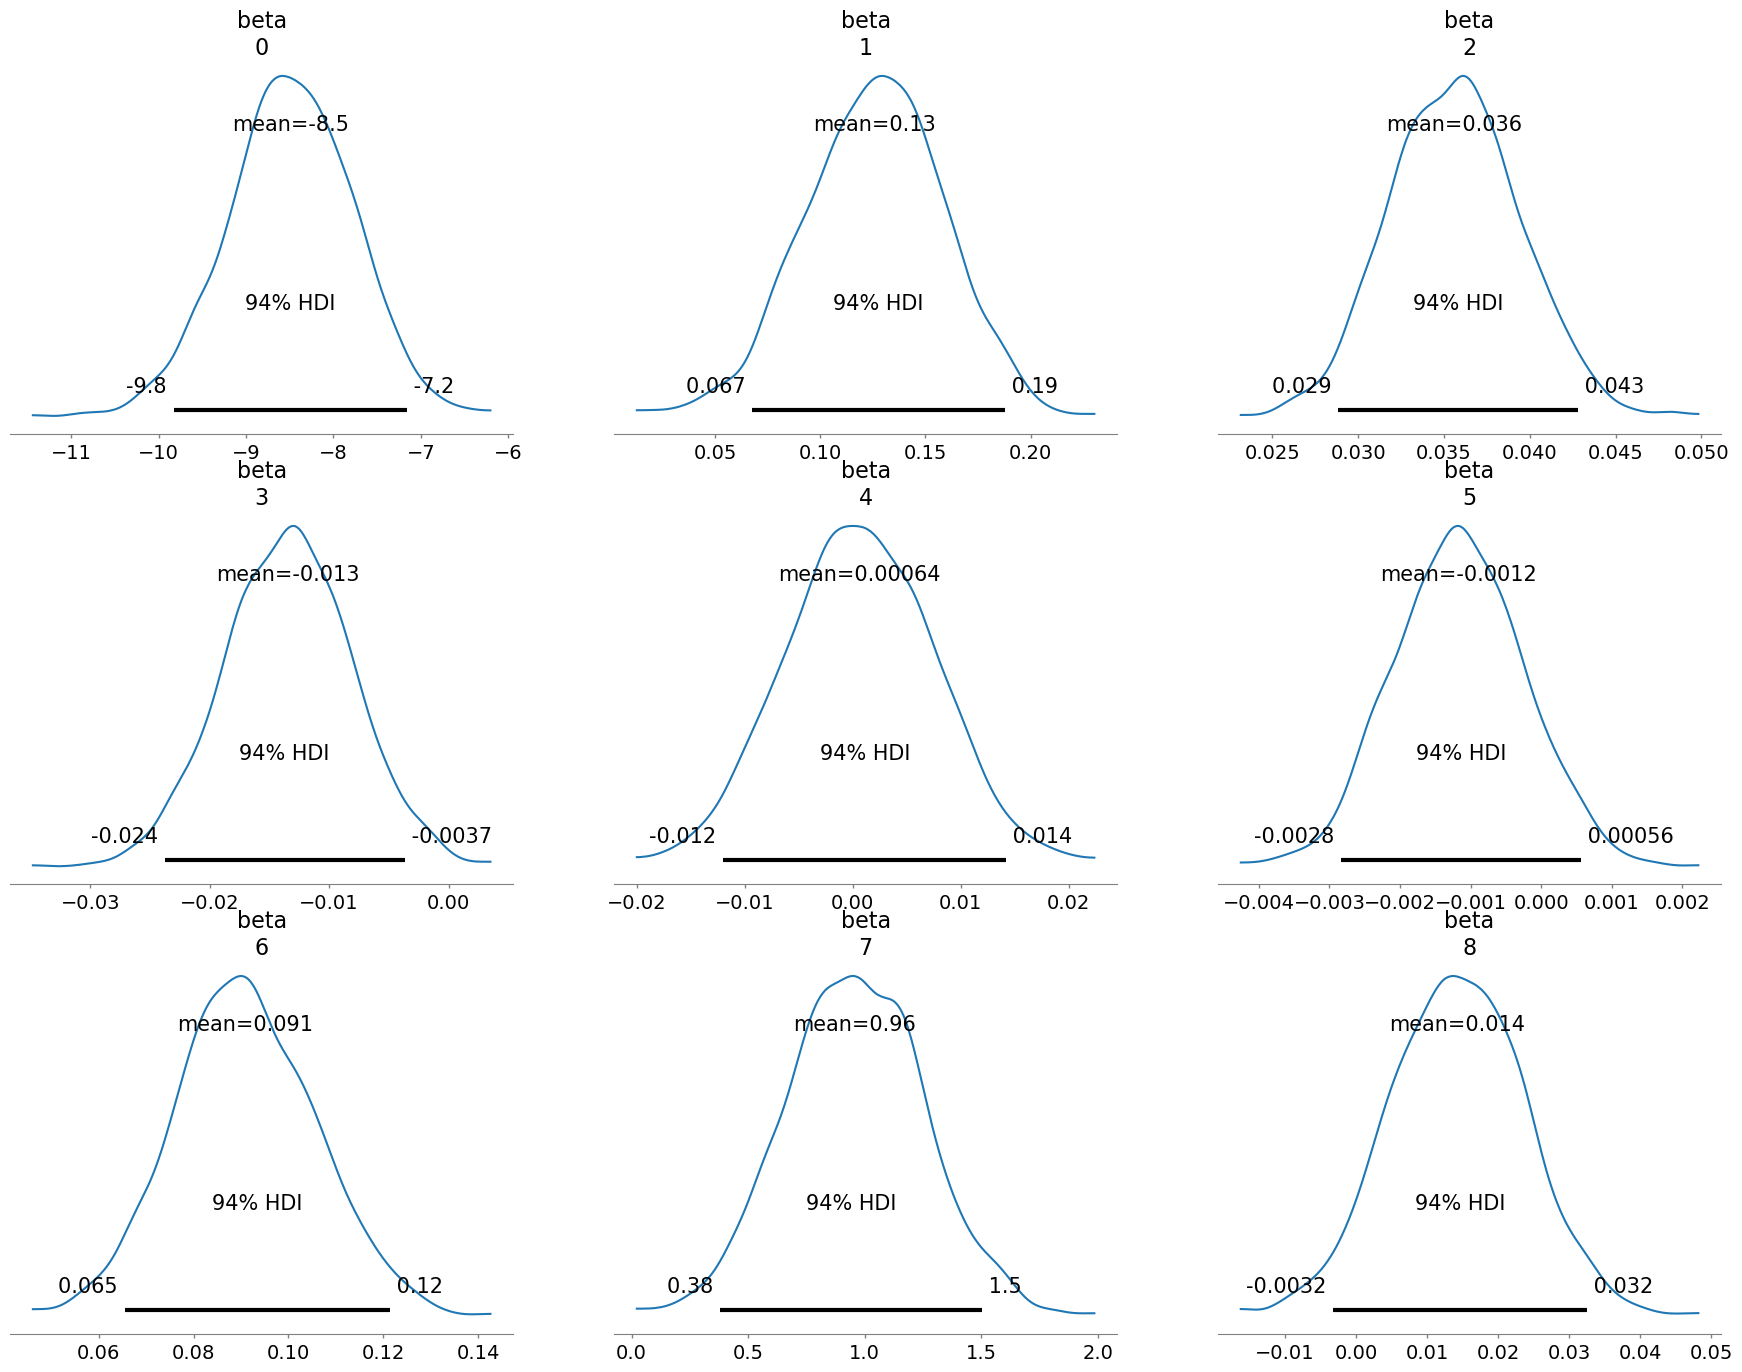

In [21]:
az.plot_posterior(idata)

<AxesSubplot: ylabel='Count'>

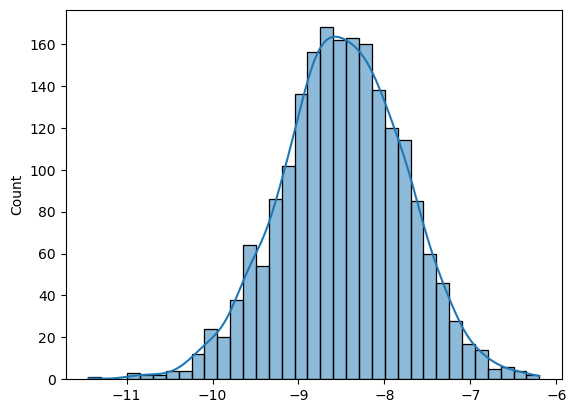

In [22]:
sns.histplot(data=az.extract(fit)['beta'][0],  kde=True)

array([[<AxesSubplot: ylabel='beta\n1'>, <AxesSubplot: >,
        <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
        <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >],
       [<AxesSubplot: ylabel='beta\n2'>, <AxesSubplot: >,
        <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
        <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >],
       [<AxesSubplot: ylabel='beta\n3'>, <AxesSubplot: >,
        <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
        <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >],
       [<AxesSubplot: ylabel='beta\n4'>, <AxesSubplot: >,
        <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
        <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >],
       [<AxesSubplot: ylabel='beta\n5'>, <AxesSubplot: >,
        <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
        <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >],
       [<AxesSubplot: ylabel='beta\n6'>, <AxesSubplot: >,
        <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >

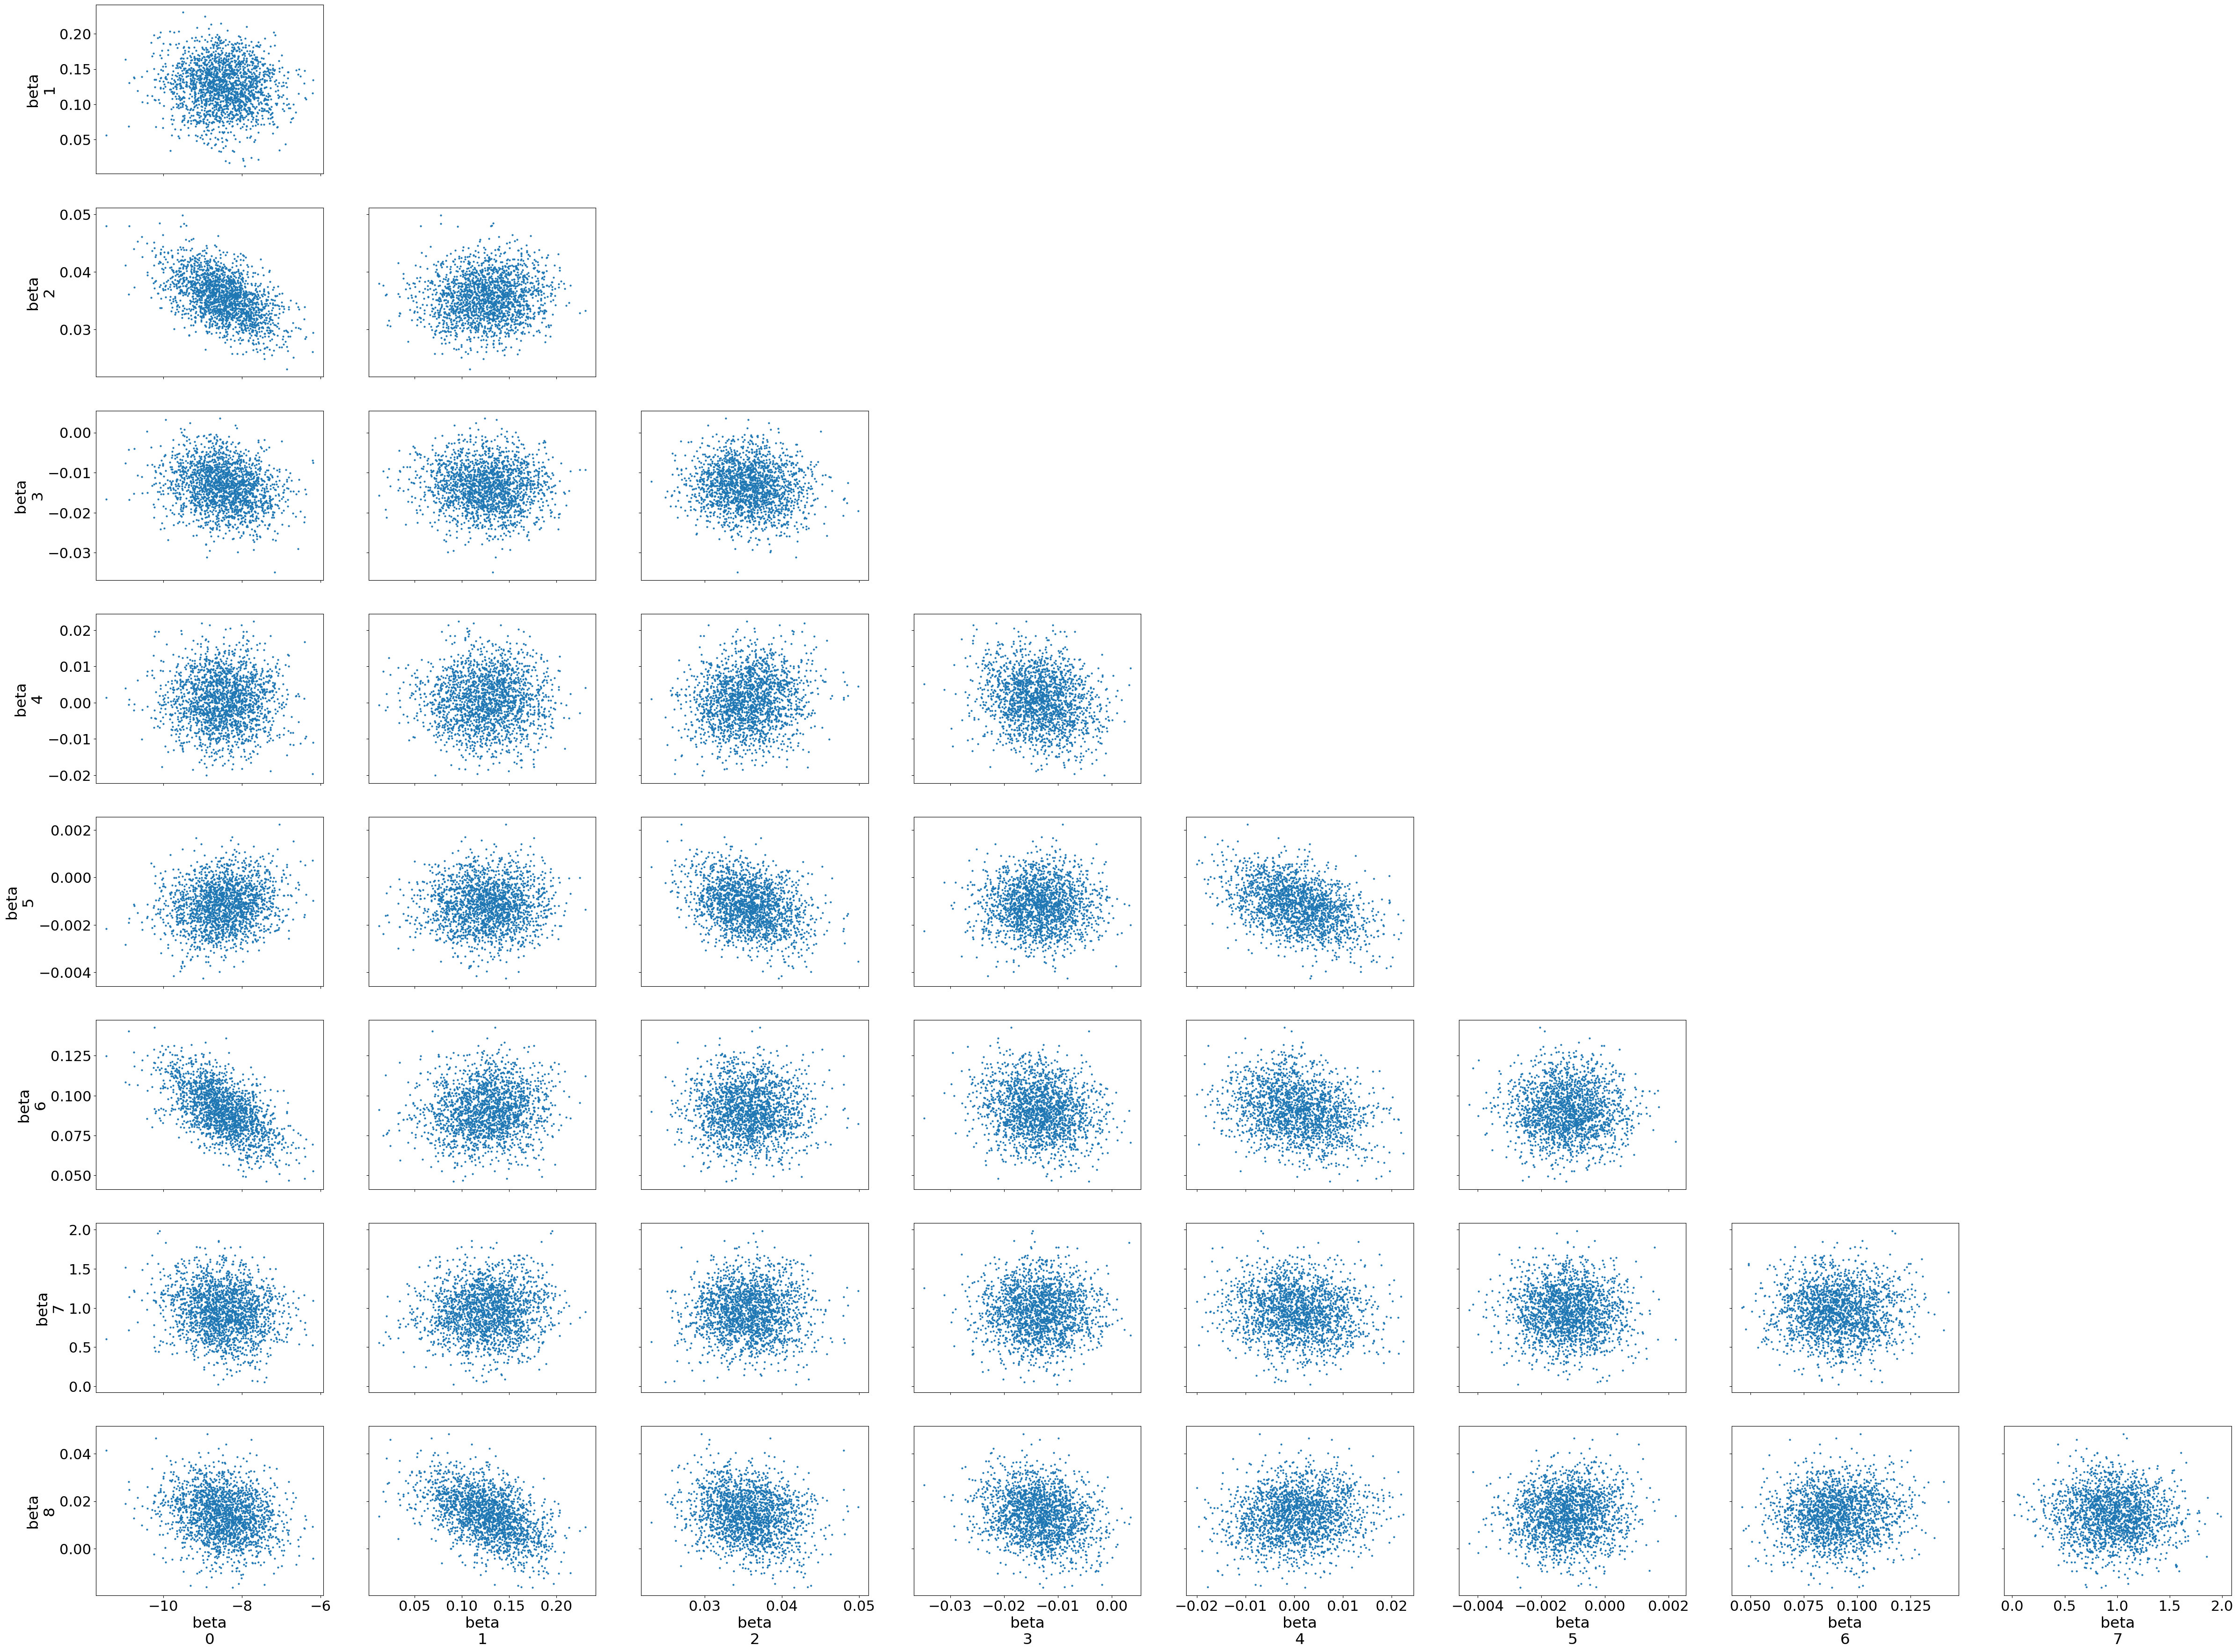

In [23]:
# we can plot pair plots
az.plot_pair(
    idata,
    divergences=True,
    textsize=22,
)

array([[<AxesSubplot: title={'center': 'beta\n0'}>,
        <AxesSubplot: title={'center': 'beta\n0'}>],
       [<AxesSubplot: title={'center': 'beta\n1'}>,
        <AxesSubplot: title={'center': 'beta\n1'}>],
       [<AxesSubplot: title={'center': 'beta\n2'}>,
        <AxesSubplot: title={'center': 'beta\n2'}>],
       [<AxesSubplot: title={'center': 'beta\n3'}>,
        <AxesSubplot: title={'center': 'beta\n3'}>],
       [<AxesSubplot: title={'center': 'beta\n4'}>,
        <AxesSubplot: title={'center': 'beta\n4'}>],
       [<AxesSubplot: title={'center': 'beta\n5'}>,
        <AxesSubplot: title={'center': 'beta\n5'}>],
       [<AxesSubplot: title={'center': 'beta\n6'}>,
        <AxesSubplot: title={'center': 'beta\n6'}>],
       [<AxesSubplot: title={'center': 'beta\n7'}>,
        <AxesSubplot: title={'center': 'beta\n7'}>],
       [<AxesSubplot: title={'center': 'beta\n8'}>,
        <AxesSubplot: title={'center': 'beta\n8'}>]], dtype=object)

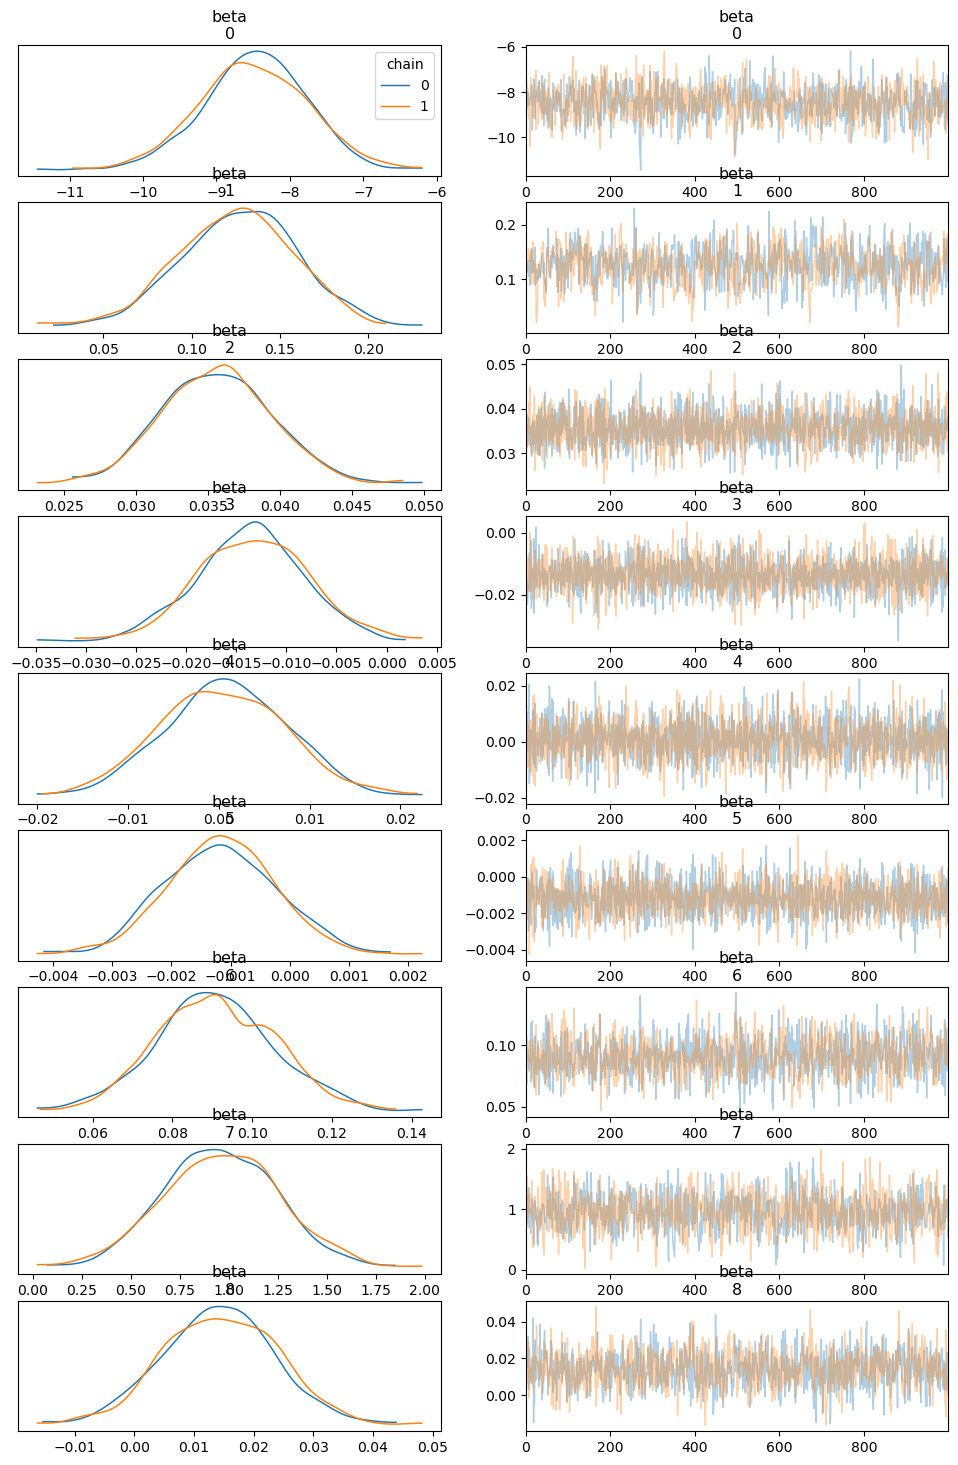

In [24]:
az.plot_trace(fit, compact=False, legend=True)

# Bayesian logistic regression same as regularized "standard" regression!

Code credit: Adapted from code by Emma Pierson

In [25]:
import numpy as np
from scipy.special import expit
import arviz as az

In [26]:
N = 5000
s = np.random.random(N,)
theta0 = 0
theta1 = 0.7
s = (s - s.mean())/s.std()
y = [int(yy) for yy in (np.random.random(N,) < expit(theta0 + theta1 * s)) * 1.]

In [27]:
from sklearn.linear_model import LogisticRegression
def logistic_regression_with_regularization(y, s, C): # C is "inverse of regularization strength"
    # print("REGULARIZATION: %2.5f" % C)
    model = LogisticRegression(fit_intercept=True, penalty='l2', C=C)
    model.fit(s.reshape(-1, 1), y)
    # print("logsitic regression results")
    # print(model.coef_)
    return model.coef_[0][0]
    
def stan_logistic_regression(y, s, C):
    stan_data = {
                'N' : len(y),
                'Nattr' : 2,
                'X' : np.transpose(np.matrix([np.ones(len(s)), s])),
                'y' : y,
                'prior_width' : np.sqrt(C) 
             }
    compiled_model = stan.build(model_code, data=stan_data, random_seed=1)
    fit = compiled_model.sample(num_chains=2, num_warmup = 200, num_samples= 1000)
    sum = az.summary(fit)
    return sum.loc['beta[1]']['mean']

In [28]:
C = 1
stanvalue = stan_logistic_regression(y, s, C)
sklearnvalue = logistic_regression_with_regularization(y, s, C)
print(C, stanvalue, sklearnvalue)

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   4% (100/2400)
Sampling:   8% (200/2400)
Sampling:  54% (1300/2400)
Sampling: 100% (2400/2400)
Sampling: 100% (2400/2400), done.
Messages received during sampling:
  Gradient evaluation took 0.000247 seconds
  1000 transitions using 10 leapfrog steps per transition would take 2.47 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000243 seconds
  1000 transitions using 10 leapfrog steps per transition would take 2.43 seconds.
  Adjust your expectations accordingly!


1 0.648 0.6462624737766374


In [29]:
C = 1e-2
stanvalue = stan_logistic_regression(y, s, C)
sklearnvalue = logistic_regression_with_regularization(y, s, C)
print(C, stanvalue, sklearnvalue)

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   4% (100/2400)
Sampling:   4% (101/2400)
Sampling:  50% (1201/2400)
Sampling: 100% (2400/2400)
Sampling: 100% (2400/2400), done.
Messages received during sampling:
  Gradient evaluation took 0.000277 seconds
  1000 transitions using 10 leapfrog steps per transition would take 2.77 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000264 seconds
  1000 transitions using 10 leapfrog steps per transition would take 2.64 seconds.
  Adjust your expectations accordingly!


0.01 0.591 0.5911199812128116


In [30]:
C = 1e-4
stanvalue = stan_logistic_regression(y, s, C)
sklearnvalue = logistic_regression_with_regularization(y, s, C)
print(C, stanvalue, sklearnvalue)

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   4% (100/2400)
Sampling:   8% (200/2400)
Sampling:  54% (1300/2400)
Sampling: 100% (2400/2400)
Sampling: 100% (2400/2400), done.
Messages received during sampling:
  Gradient evaluation took 0.000297 seconds
  1000 transitions using 10 leapfrog steps per transition would take 2.97 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000256 seconds
  1000 transitions using 10 leapfrog steps per transition would take 2.56 seconds.
  Adjust your expectations accordingly!


0.0001 0.068 0.06772473940267774


In [31]:
C = 1e-8
stanvalue = stan_logistic_regression(y, s, C)
sklearnvalue = logistic_regression_with_regularization(y, s, C)
print(C, stanvalue, sklearnvalue)

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   4% (100/2400)
Sampling:   8% (200/2400)
Sampling:  54% (1300/2400)
Sampling: 100% (2400/2400)
Sampling: 100% (2400/2400), done.
Messages received during sampling:
  Gradient evaluation took 0.000257 seconds
  1000 transitions using 10 leapfrog steps per transition would take 2.57 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000258 seconds
  1000 transitions using 10 leapfrog steps per transition would take 2.58 seconds.
  Adjust your expectations accordingly!


1e-08 0.0 7.618259259390657e-06
